# CSE 7324 Lab 5: Wide and Deep Networks
### Thomas Adams, Suleiman Hijazeen, Nancy Le and Andrew Whigham
---

### 1. Preparation
---

Austin Animal Center is the largest no-kill shelter in the United States and provides shelter to more than 16,000 animals each year. As a no-kill shelter they refuse to euthanize any animal unless the animal has a terminal medical issue and is in pain or if the animal is a danger to the public or to the shelter staff. The Center keeps track of each animal that comes through their doors and keeps a record of the animal’s outcome; that is whether they were adopted, transferred to a partner shelter or sanctuary or one of many other outcomes. If the shelter could predict an animal’s outcome based on the animal’s characteristics, they could be much more efficient with having animals leave the shelter by knowing which animals they should be able to adopt out and which animals they should transfer to other shelters or sanctuaries.

This lab examines the Austin Animal Center animal outcome data set to specifically look at all types of animals in the dataset and the outcome of each animal and attempts to build an accurate model of predicting the outcome. This differs from our previous use of this dataset which was limited to cats. Our prediction model can analyze how likely an animal be adopted or stay in a shelter forever with high accuracy. This binary classification model could serve the Austin Animal Center and other parties such as other shelters or shelter donors that are looking at issuing a no-kill ordinance for their shelters.


In [132]:
# dependencies
import pandas as pd
import numpy as np
import missingno as msno 
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split

from textwrap import wrap
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
import math
%matplotlib inline

#### 1.1 Define Class Variables
---

In [133]:
# import data
shelter_outcomes =  pd.read_csv("../Project4/Data/aac_shelter_outcomes.csv")
# filter animal type for just cats
#cats = shelter_outcomes[shelter_outcomes['animal_type'] == 'Cat']
cats = shelter_outcomes
#print(cats.head())

# remove age_upon_outcome and recalculate to standard units (days)
age = cats.loc[:,['datetime', 'date_of_birth']]
# convert to datetime
age.loc[:,'datetime'] = pd.to_datetime(age['datetime'])
age.loc[:,'date_of_birth'] = pd.to_datetime(age['date_of_birth'])
# calculate cat age in days
cats.loc[:,'age'] = (age.loc[:,'datetime'] - age.loc[:,'date_of_birth']).dt.days
# get dob info
cats['dob_month'] = age.loc[:, 'date_of_birth'].dt.month
cats['dob_day'] = age.loc[:, 'date_of_birth'].dt.day
cats['dob_dayofweek'] = age.loc[:, 'date_of_birth'].dt.dayofweek
# get month from datetime
cats['month'] = age.loc[:,'datetime'].dt.month
# get day of month
cats['day'] = age.loc[:,'datetime'].dt.day
# get day of week
cats['dayofweek'] = age.loc[:, 'datetime'].dt.dayofweek
# get hour of day
cats['hour'] = age.loc[:, 'datetime'].dt.hour
# get quarter
cats['quarter'] = age.loc[:, 'datetime'].dt.quarter

# clean up breed attribute
# get breed attribute for processing
# convert to lowercase, remove mix and strip whitespace
# remove space in 'medium hair' to match 'longhair' and 'shorthair'
# split on either space or '/'
breed = cats.loc[:, 'breed'].str.lower().str.replace('mix', '').str.replace('medium hair', 'mediumhair').str.strip().str.split('/', expand=True)
cats['breed'] = breed[0]
cats['breed1'] = breed[1]

# clean up color attribute
# convert to lowercase
# strip spaces
# split on '/'
color = cats.loc[:, 'color'].str.lower().str.strip().str.split('/', expand=True)
cats['color'] = color[0]
cats['color1'] = color[1]

# clean up sex_upon_outcome
sex = cats['sex_upon_outcome'].str.lower().str.strip().str.split(' ', expand=True)
sex[0].replace('spayed', True, inplace=True)
sex[0].replace('neutered', True, inplace=True)
sex[0].replace('intact', False, inplace=True)
sex[1].replace(np.nan, 'unknown', inplace=True)
cats['spayed_neutered'] = sex[0]
cats['sex'] = sex[1]

# add in domesticated attribute
cats['domestic'] = np.where(cats['breed'].str.contains('domestic'), 1, 0)

# combine outcome and outcome subtype into a single attribute
cats['outcome_subtype'] = cats['outcome_subtype'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome_type'] = cats['outcome_type'].str.lower().str.replace(' ', '-').fillna('unknown')
cats['outcome'] = cats['outcome_type'] + '_' + cats['outcome_subtype']

# drop unnecessary columns
cats.drop(columns=['animal_id', 'name', 'age_upon_outcome', 'date_of_birth', 'datetime', 'monthyear', 'sex_upon_outcome', 'outcome_subtype', 'outcome_type'], inplace=True)
#print(cats['outcome'].value_counts())

cats.head()


,animal_type,breed,color,age,dob_month,dob_day,dob_dayofweek,month,day,dayofweek,hour,quarter,breed1,color1,spayed_neutered,sex,domestic,outcome
0,Cat,domestic shorthair,orange tabby,15,7,7,0,7,22,1,16,3,None,None,False,male,1,transfer_partner
1,Dog,beagle,white,366,11,6,1,11,7,3,11,4,None,brown,True,female,0,transfer_partner
2,Dog,pit bull,blue,429,3,31,6,6,3,1,14,2,None,white,True,male,0,adoption_unknown
3,Dog,miniature schnauzer,white,3300,6,2,3,6,15,6,15,2,None,None,True,male,0,transfer_partner
4,Other,bat,brown,181,1,7,1,7,7,0,14,3,None,None,unknown,unknown,0,euthanasia_rabies-risk


In [134]:
print("Default datatypes of shelter cat outcomes:\n")
print(cats.dtypes)

print("\nBelow is a description of the attributes in the cats dataframe:\n")

Default datatypes of shelter cat outcomes:

animal_type        object
breed              object
color              object
age                 int64
dob_month           int64
dob_day             int64
dob_dayofweek       int64
month               int64
day                 int64
dayofweek           int64
hour                int64
quarter             int64
breed1             object
color1             object
spayed_neutered    object
sex                object
domestic            int64
outcome            object
dtype: object

Below is a description of the attributes in the cats dataframe:



In [135]:
print('Below is a listing of the target classes and their distributions:')
cats['outcome'].value_counts()

Below is a listing of the target classes and their distributions:


adoption_unknown                  27186
transfer_partner                  19660
return-to-owner_unknown           14354
adoption_foster                    5558
transfer_scrp                      3211
euthanasia_suffering               2514
euthanasia_rabies-risk             2417
transfer_snr                        626
euthanasia_aggressive               506
adoption_offsite                    367
died_in-kennel                      335
disposal_unknown                    307
euthanasia_medical                  259
euthanasia_unknown                  170
died_in-foster                      164
rto-adopt_unknown                   150
euthanasia_behavior                 142
died_unknown                         87
died_enroute                         45
died_at-vet                          33
euthanasia_underage                  28
euthanasia_at-vet                    26
missing_in-foster                    18
euthanasia_court/investigation       18
died_in-surgery                      16


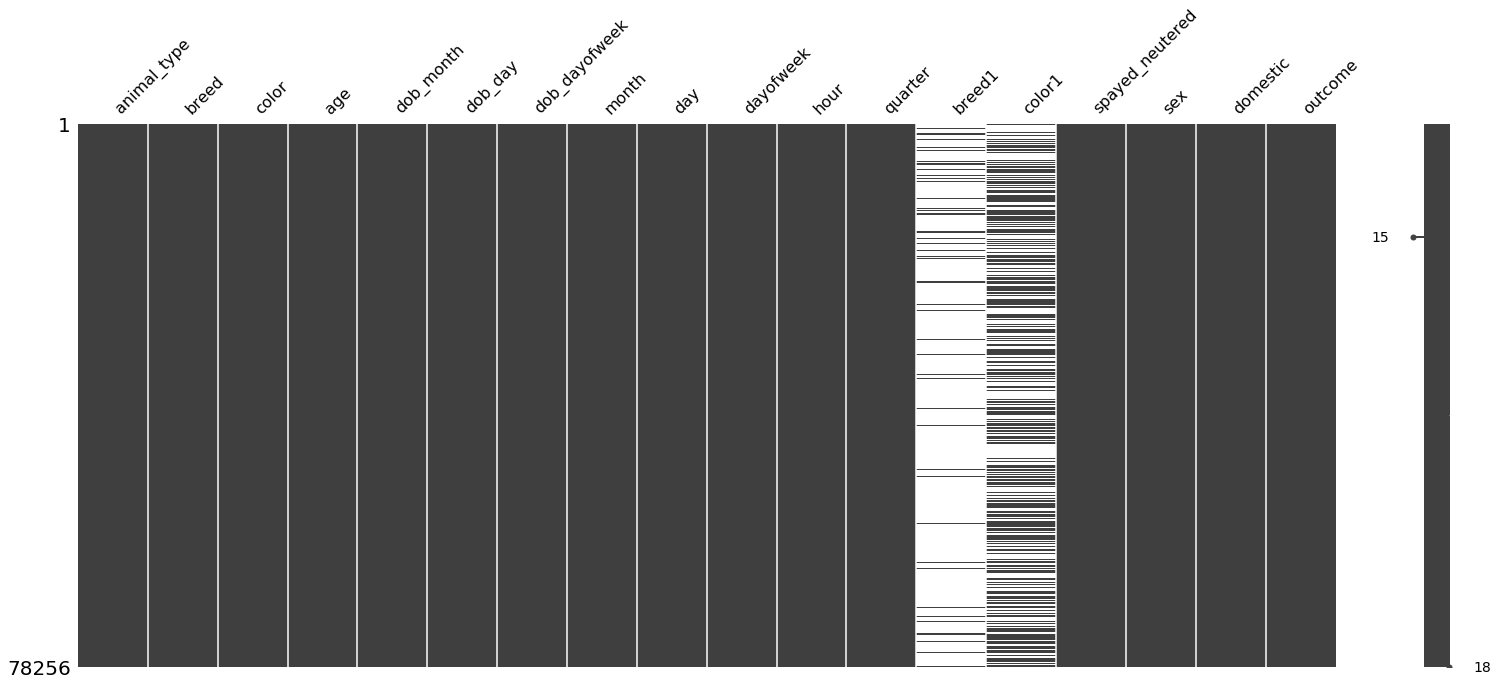

In [136]:
msno.matrix(cats )

#### 1.2 Split the Data
Here we will split the training and test datasets. Since we have almost 80k instances of data, the likelihood that we will use ~64k unrepresentative examples is extremely small. Thus, we have opted for the simple 80/20 split.

Here we will also encode the categorical feature *outcome* as integers 1 and 0 to establish our binary classification. Because we are interested primarily in whether or not the animal was ultimately adopted, we have categorized anything as 



In [137]:
cats.drop(columns=['breed1'], inplace=True)
# Breed, Color, Color1, Spayed_Netured and Sex attributes need to be one hot encoded
cats_ohe = pd.get_dummies(cats, columns=['breed', 'color', 'color1', 'spayed_neutered', 'sex','animal_type'])
cats_ohe.head()
#output is converted from string to catogries 0 and 1 for adopted or not
out_t={'relocate_unknown':0,'euthanasia_court/investigation':0,'euthanasia_behavior':0,'euthanasia_suffering' : 0, 'died_in-kennel' : 0, 'return-to-owner_unknown' : 0, 'transfer_partner' : 0, 'euthanasia_at-vet' : 0, 'adoption_foster' : 1, 'died_in-foster' : 0, 'transfer_scrp' : 0, 'euthanasia_medical' : 0, 'transfer_snr' : 0, 'died_enroute' : 0, 'rto-adopt_unknown' : 1, 'missing_in-foster' : 0, 'adoption_offsite' : 1, 'adoption_unknown' :1,'euthanasia_rabies-risk' : 0, 'unknown_unknown' : 0, 'adoption_barn' : 0, 'died_unknown' : 0, 'died_in-surgery' : 0, 'euthanasia_aggressive' : 0, 'euthanasia_unknown' : 0, 'missing_unknown' : 0, 'missing_in-kennel' : 0, 'missing_possible-theft' : 0, 'died_at-vet' : 0, 'disposal_unknown' : 0, 'euthanasia_underage' : 0, 'transfer_barn' : 0}

# separate outcome from data
outcome = cats_ohe['outcome']
cats_ohe.drop(columns=['outcome'])

print(cats_ohe.head())

# split the data
X_train, X_test, y_train, y_test = train_test_split(cats_ohe, outcome, test_size=0.2, random_state=0)
X_train.drop(columns=['outcome'], inplace=True)
X_test.drop(columns=['outcome'], inplace=True)
y_train = np.asarray([out_t[item] for item in y_train])
y_test = np.asarray([out_t[item] for item in y_test])
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


    age  dob_month  dob_day  dob_dayofweek  month  day  dayofweek  hour  \
0    15          7        7              0      7   22          1    16   
1   366         11        6              1     11    7          3    11   
2   429          3       31              6      6    3          1    14   
3  3300          6        2              3      6   15          6    15   
4   181          1        7              1      7    7          0    14   

   quarter  domestic        ...         spayed_neutered_True  \
0        3         1        ...                            0   
1        4         0        ...                            1   
2        2         0        ...                            1   
3        2         0        ...                            1   
4        3         0        ...                            0   

   spayed_neutered_unknown  sex_female  sex_male  sex_unknown  \
0                        0           0         1            0   
1                        0        

In [138]:
from sklearn import metrics as mt
from sklearn.preprocessing import OneHotEncoder
import keras
# from keras.models import Sequential
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
keras.__version__

'2.2.4'

In [139]:
x_train_ar=X_train.values
y_target_ar=np.asarray(y_train)
x_test_ar=X_test.values
y_test_ar=np.asarray(y_test)
x_train_ar = StandardScaler().fit(x_train_ar).transform(x_train_ar)

print(x_train_ar.shape)
print(y_target_ar.shape)
unique, counts = np.unique(y_target_ar, return_counts=True)
np.asarray((unique, counts))

(62604, 473)
(62604,)


array([[    0,     1],
       [35934, 26670]])

In [140]:

for i in range(78256):
 sex[0][i]=str(sex[0][i])


In [141]:
cats=cats.drop(columns=['color1'])
cats['spayed_neutered'] = sex[0]
cats=cats.dropna() 
cats=cats.drop(columns=['outcome'])
cats

,animal_type,breed,color,age,dob_month,dob_day,dob_dayofweek,month,day,dayofweek,hour,quarter,spayed_neutered,sex,domestic
0,Cat,domestic shorthair,orange tabby,15,7,7,0,7,22,1,16,3,False,male,1
1,Dog,beagle,white,366,11,6,1,11,7,3,11,4,True,female,0
2,Dog,pit bull,blue,429,3,31,6,6,3,1,14,2,True,male,0
3,Dog,miniature schnauzer,white,3300,6,2,3,6,15,6,15,2,True,male,0
4,Other,bat,brown,181,1,7,1,7,7,0,14,3,unknown,unknown,0
5,Dog,leonberger,brown,126,6,3,0,10,7,0,13,4,False,male,0
6,Other,squirrel,tan,365,12,13,4,12,13,5,12,4,unknown,unknown,0
7,Dog,chihuahua shorthair,brown,1111,11,23,2,12,8,0,15,4,True,female,0
8,Cat,domestic shorthair,blue tabby,59,6,16,0,8,14,3,18,3,False,female,1
9,Cat,domestic shorthair,white,95,3,26,2,6,29,6,17,2,True,female,1


In [142]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
categorical_headers = ['animal_type','breed','color',
                       'spayed_neutered','sex']
numeric_headers = ["age", "dob_month", "dob_day","dob_dayofweek","month","day","dayofweek","hour","quarter"]
encoders = dict() 
for col in categorical_headers:
    cats[col] = cats[col].str.strip()

    encoders[col] = LabelEncoder() # save the encoder
    cats[col+'_int'] = encoders[col].fit_transform(cats[col])
for col in numeric_headers:
    cats[col] = cats[col].astype(np.float)
    
    
    ss = StandardScaler()
    cats[col] = ss.fit_transform(cats[col].values.reshape(-1, 1))


In [143]:
from sklearn.model_selection import StratifiedShuffleSplit
X_train, X_test, y_train, y_test=train_test_split(cats, outcome, test_size=0.2)

print(X_train.shape)
print(X_test.shape)


(62604, 20)
(15652, 20)


In [144]:

ohe = OneHotEncoder()
X_train_ohe = ohe.fit_transform(X_train[categorical_headers].values)
X_test_ohe = ohe.fit_transform(X_test[categorical_headers].values)

print(X_test_ohe.shape)
print(X_train_ohe.shape)

(15652, 327)
(62604, 403)


In [145]:
y_train = np.asarray([out_t[item] for item in y_train])
y_test = np.asarray([out_t[item] for item in y_test])



In [146]:
# let's start as simply as possible, without any feature preprocessing
categorical_headers_ints = [x+'_int' for x in categorical_headers]

# we will forego one-hot encoding right now and instead just scale all inputs
#   this is just to get an example running in Keras (don't ever do this)
feature_columns = categorical_headers_ints+numeric_headers
X_train_ar =  ss.fit_transform(X_train[feature_columns].values).astype(np.float32)
X_test_ar =  ss.transform(X_test[feature_columns].values).astype(np.float32)

y_train_ar = np.asarray(y_train)
y_test_ar = np.asarray(y_test)

print(feature_columns)

['animal_type_int', 'breed_int', 'color_int', 'spayed_neutered_int', 'sex_int', 'age', 'dob_month', 'dob_day', 'dob_dayofweek', 'month', 'day', 'dayofweek', 'hour', 'quarter']


#### Identify Cross Product Features

For crossed columns, we will be crossing *breed* with *animal_type*, *sex* with *color*, and *sex* with *spayed_neutered*:
- Breed / Animal Type: Since breeds are specific types of dog or cat, these are highly correlated
- Sex / Color: Some cats and dogs tend to have correlations with a certain color depending on their gender
- Sex / Spayed or Neutered: These are only applicable to specific genders so there will be very high correlation

These will be implemented in the modeling section.

---

#### Metrics

The metric we will use to determine the performance of our model will be the macro-averaged F1 score. We are using macro-averaging instead of micro since we have a class imbalance problem. The number of instances for each class varies quite greatly and we want to use a metric that will weigh the scores equally for each class.

We are using F1 as we care both about precision and recall. The goal of the Austin Animal Center is to determine in advance how likely an animal is to be adopted. In any case, mislabeling has dire consequences. If we classify an animal as likely adoptable but are incorrect (False Positive - need high **precision**), it could have financial consequences. If we incorrectly ignore an animal because we think it wouldn't be adopted (False Negative - need high **recall**), we missed out on providing a home for a pet in need. 

Since keras does not provide recall, precision, or f1 in their metrics package as a result of the 2.0 release, we will need to implement our own custom metric. We found the following post on datascience stackexchange which helped detail this process below. Though fairly straightforward, we have provided comments to explain the code we have leveraged.

https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model

https://github.com/keras-team/keras/wiki/Keras-2.0-release-notes

---


In [1]:
#create custom f1 metric from custom recall and precision
from keras.layers import concatenate
from keras import backend as K

def recall_m(y_true, y_pred): # recall is true positive / (total actual positive)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1))) # actual positives are just y_true
        # recall is true positive / (total actual positive).. the episol is a small number to prevent divide by zero errors
        recall = true_positives / (possible_positives + K.epsilon()) 
        return recall

def precision_m(y_true, y_pred): #precision is true positives / (total predicted positives)
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1))) # y_true * y_pred will only give 1 for true positives
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1))) # predicted positives
        # (true positive / predicted positive).. the episol is a small number to prevent divide by zero errors
        precision = true_positives / (predicted_positives + K.epsilon())   
        return precision

def f1_m(y_true, y_pred): # f1 = 2 * (precision*recall / precision + recall)
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon())) 

Using TensorFlow backend.


In [ ]:
inputsSparse = Input(shape=(X_train_ohe.shape[1],),sparse=True, name='X_ohe')
xSparse = Dense(units=100, activation='relu', name='ohe_1')(inputsSparse)
xSparse1 = Dense(units=50, activation='relu', name='ohe_2')(xSparse)
# create dense input branch for numeric
inputsDense = Input(shape=(X_train_ar.shape[1],),sparse=False, name='X_Numeric')
xDense = Dense(units=100, activation='relu',name='num_1')(inputsDense)
xDense1 = Dense(units=50, activation='relu',name='num_2')(xDense)
x = concatenate([xSparse1, xDense1], name='concat')
predictions = Dense(1,activation='sigmoid', name='combined')(x)

# This creates a model that includes
# the Input layer and Dense layers
model = Model(inputs=[inputsSparse,inputsDense], outputs=predictions)

model.summary()

### 2. Modeling
---

#### 2.1 Wide and Deep Networks
---

In [148]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

model.fit([ X_train_ohe, X_train_ar ], # inputs for each branch are a list
          y_train, 
          epochs=20, 
          batch_size=50, 
          verbose=0)


In [149]:
yhat = model.predict([X_train_ohe,
                      X_train_ar]) # each branch has an input

yhat = np.round(yhat)
print(mt.confusion_matrix(y_train_ar,yhat),mt.accuracy_score(y_train_ar,yhat))


[[28752  7248]
 [ 6048 20556]] 0.7876174046386812


In [150]:
recall = model.evaluate([ X_train_ohe, X_train_ar ], y_train_ar, verbose=0)
recall

[0.1441550043524435, 0.7876174046424896, 0.7485503446643752]

In [151]:

# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = [] # keep track of inputs for each branch
X_ints_test = []# keep track of inputs for each branch
all_inputs = [] # this is what we will give to keras.Model inputs
all_branch_outputs = [] # this is where we will keep track of output of each branch

for col in categorical_headers_ints:
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs ) # keep track of created inputs
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_branch_outputs.append(x) 
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),sparse=False, name='numeric'))
x = Dense(units=100, activation='relu',name='numeric_1')(all_inputs[-1])
all_branch_outputs.append( Dense(units=50,activation='relu', name='numeric_2')(x) )

# merge the branches together
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
animal_type_int (InputLayer)    (None, 1)            0                                            
__________________________________________________________________________________________________
breed_int (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
color_int (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
spayed_neutered_int (InputLayer (None, 1)            0                                            
__________________________________________________________________________________________________
sex_int (I

In [152]:
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])

model.fit(X_ints_train + [X_train_ar], # create a list of inputs for embeddings
        y_train, epochs=20, batch_size=32, verbose=1)

Epoch 1/20
62604/62604 [==============================] - 3s 45us/step - loss: 0.2119 - acc: 0.6663
Epoch 2/20
62604/62604 [==============================] - 2s 31us/step - loss: 0.1719 - acc: 0.7542
Epoch 3/20
62604/62604 [==============================] - 2s 31us/step - loss: 0.1568 - acc: 0.7693
Epoch 4/20
62604/62604 [==============================] - 2s 30us/step - loss: 0.1525 - acc: 0.7737
Epoch 5/20
62604/62604 [==============================] - 2s 31us/step - loss: 0.1506 - acc: 0.7761
Epoch 6/20
62604/62604 [==============================] - 2s 30us/step - loss: 0.1493 - acc: 0.7787
Epoch 7/20
62604/62604 [==============================] - 2s 31us/step - loss: 0.1484 - acc: 0.7805
Epoch 8/20
62604/62604 [==============================] - 2s 31us/step - loss: 0.1476 - acc: 0.7817
Epoch 9/20
62604/62604 [==============================] - 2s 31us/step - loss: 0.1469 - acc: 0.7837
Epoch 10/20
62604/62604 [==============================] - 2s 31us/step - loss: 0.1463 - acc: 0.7847

In [153]:
yhat = np.round(model.predict(X_ints_test + [X_test_ar]))
print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

[[7273 1722]
 [1501 5156]] 0.7940838231535906


#### Model cross_columns1

In [154]:
# 'workclass','education','marital_status',
# 'occupation','relationship','race',
# 'sex','country'
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
cross_columns = [['breed','animal_type'],
                 ['color', 'sex'],
                 ['spayed_neutered', 'sex'] ]

#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=100,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)



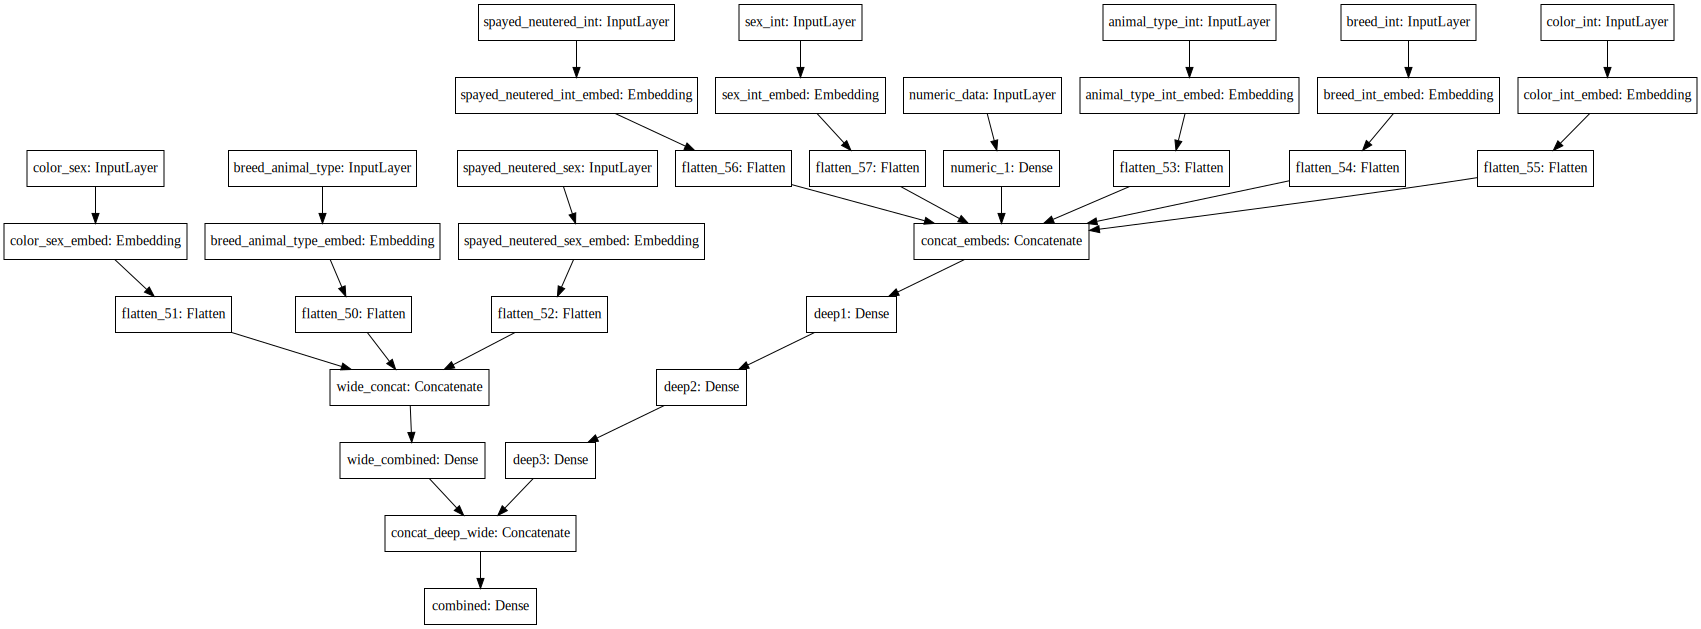

In [155]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [156]:
#%%time

model.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history = model.fit(X_ints_train+ [X_train_ar],
                    y_train, 
                    epochs=30, 
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_ar], y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/30
62604/62604 [==============================] - 3s 51us/step - loss: 0.1537 - acc: 0.7694 - f1_m: 0.7308 - val_loss: 0.1503 - val_acc: 0.7739 - val_f1_m: 0.7524
Epoch 2/30
62604/62604 [==============================] - 2s 33us/step - loss: 0.1456 - acc: 0.7838 - f1_m: 0.7436 - val_loss: 0.1446 - val_acc: 0.7839 - val_f1_m: 0.7467
Epoch 3/30
62604/62604 [==============================] - 2s 34us/step - loss: 0.1430 - acc: 0.7869 - f1_m: 0.7460 - val_loss: 0.1459 - val_acc: 0.7816 - val_f1_m: 0.7537
Epoch 4/30
62604/62604 [==============================] - 2s 33us/step - loss: 0.1411 - acc: 0.7908 - f1_m: 0.7501 - val_loss: 0.1421 - val_acc: 0.7869 - val_f1_m: 0.7501
Epoch 5/30
62604/62604 [==============================] - 2s 33us/step - loss: 0.1397 - acc: 0.7928 - f1_m: 0.7532 - val_loss: 0.1414 - val_acc: 0.7925 - val_f1_m: 0.7494
Epoch 6/30
62604/62604 [==============================] - 2s 33us/step - loss: 0.1384 - acc: 0.

In [157]:
yhat = np.round(model.predict(X_ints_test + [X_test_ar]))
print(mt.confusion_matrix(y_test,yhat), mt.accuracy_score(y_test,yhat))

[[7493 1502]
 [1741 4916]] 0.7928060311781242


#### Model cross_columns2

In [158]:
# 'workclass','education','marital_status',
# 'occupation','relationship','race',
# 'sex','country'

cross_columns = [['breed','sex'],
                 ['color', 'spayed_neutered']]

#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=100,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
    
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

model1 = Model(inputs=all_inputs, outputs=final_branch)



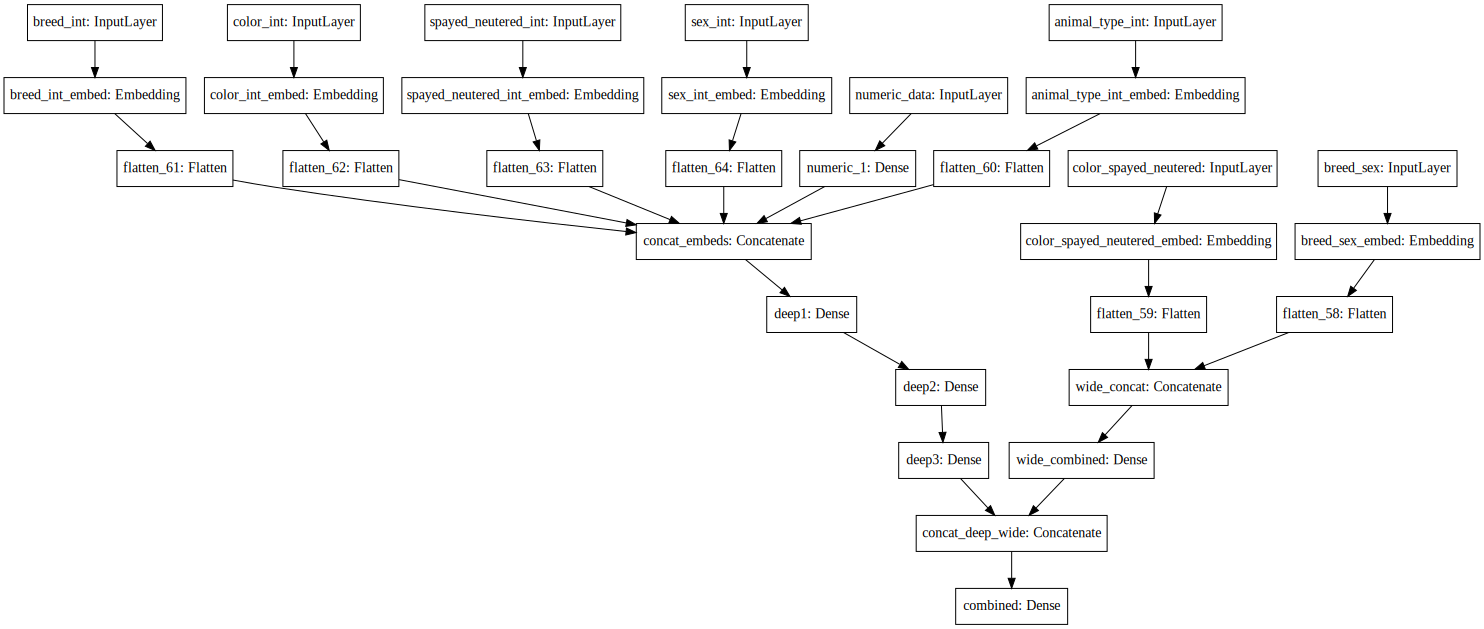

In [159]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [160]:
%%time

model1.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
history1 = model1.fit(X_ints_train+ [X_train_ar],
                    y_train, 
                    epochs=30,  
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_ar], y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/30
62604/62604 [==============================] - 3s 52us/step - loss: 0.1530 - acc: 0.7700 - f1_m: 0.7277 - val_loss: 0.1475 - val_acc: 0.7784 - val_f1_m: 0.7227
Epoch 2/30
62604/62604 [==============================] - 2s 33us/step - loss: 0.1459 - acc: 0.7834 - f1_m: 0.7440 - val_loss: 0.1444 - val_acc: 0.7842 - val_f1_m: 0.7376
Epoch 3/30
62604/62604 [==============================] - 2s 33us/step - loss: 0.1436 - acc: 0.7868 - f1_m: 0.7468 - val_loss: 0.1432 - val_acc: 0.7874 - val_f1_m: 0.7475
Epoch 4/30
62604/62604 [==============================] - 2s 33us/step - loss: 0.1421 - acc: 0.7907 - f1_m: 0.7520 - val_loss: 0.1425 - val_acc: 0.7871 - val_f1_m: 0.7437
Epoch 5/30
62604/62604 [==============================] - 2s 33us/step - loss: 0.1407 - acc: 0.7929 - f1_m: 0.7545 - val_loss: 0.1421 - val_acc: 0.7881 - val_f1_m: 0.7476
Epoch 6/30
62604/62604 [==============================] - 2s 33us/step - loss: 0.1398 - acc: 0.

Text(0.5, 0, 'epochs Model 1')

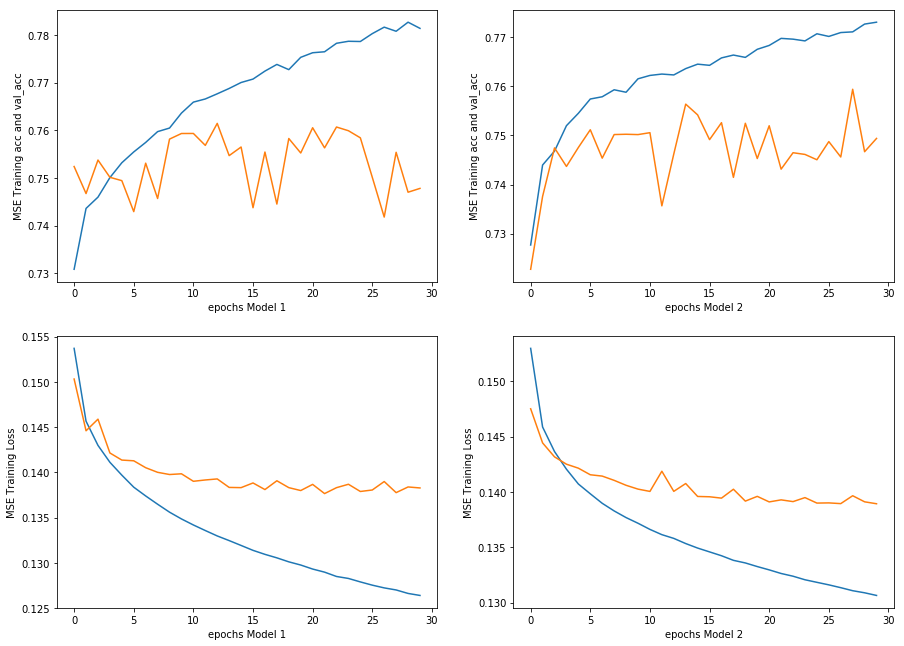

In [161]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(15,11))
plt.subplot(2,2,2)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs Model 2')
plt.plot(history1.history['f1_m'])
plt.plot(history1.history['val_f1_m'])


plt.subplot(2,2,4)
plt.plot(history1.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs Model 2')
plt.plot(history1.history['val_loss'])
plt.xlabel('epochs Model 2')



plt.subplot(2,2,1)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs Model 1')
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])


plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs Model 1')
plt.plot(history.history['val_loss'])
plt.xlabel('epochs Model 1')

Model 1 attribute crossing: 
 A-breed ,animal_type
 B-sex ,color
 C-sex, spayed_neutered

model 2 is crossing :
 A-breed,sex
 B-color', spayed_neutered


shown above the accuracy and the valdation for both model1 and model2 i want to argue that model 1 is slightly better than model2 because of the following reasons :

1- the elements model 1 is crossing are highly corrlated, females always have more colors , breed is highly colrated with animal type so it provide a better genrliztion  

2- because of the first point , model 1 resulted in a better over all accurace and valdation accuracy than model 2

3- best accracy for model1 is 0.7781 and validation is 0.7545


### Model A 5 layars

In [162]:
# 'workclass','education','marital_status',
# 'occupation','relationship','race',
# 'sex','country'
cross_columns = [['breed','animal_type'],
                 ['color', 'sex'],
                 ['spayed_neutered', 'sex'] ]


#'workclass','education','marital_status','occupation','relationship','race','sex','country'

# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')
wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=100,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=15,activation='relu', name='deep4')(deep_branch)   
final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

modelA = Model(inputs=all_inputs, outputs=final_branch)

In [163]:
%%time

modelA.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
historyA = modelA.fit(X_ints_train+ [X_train_ar],
                    y_train, 
                    epochs=30,  
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_ar], y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/30
62604/62604 [==============================] - 3s 56us/step - loss: 0.1526 - acc: 0.7722 - f1_m: 0.7329 - val_loss: 0.1464 - val_acc: 0.7818 - val_f1_m: 0.7333
Epoch 2/30
62604/62604 [==============================] - 2s 35us/step - loss: 0.1440 - acc: 0.7869 - f1_m: 0.7451 - val_loss: 0.1437 - val_acc: 0.7874 - val_f1_m: 0.7392
Epoch 3/30
62604/62604 [==============================] - 2s 36us/step - loss: 0.1416 - acc: 0.7917 - f1_m: 0.7505 - val_loss: 0.1426 - val_acc: 0.7906 - val_f1_m: 0.7517
Epoch 4/30
62604/62604 [==============================] - 2s 35us/step - loss: 0.1401 - acc: 0.7943 - f1_m: 0.7535 - val_loss: 0.1417 - val_acc: 0.7904 - val_f1_m: 0.7495
Epoch 5/30
62604/62604 [==============================] - 2s 36us/step - loss: 0.1389 - acc: 0.7957 - f1_m: 0.7548 - val_loss: 0.1411 - val_acc: 0.7898 - val_f1_m: 0.7455
Epoch 6/30
62604/62604 [==============================] - 2s 36us/step - loss: 0.1378 - acc: 0.

### Model B 7 layers

In [164]:
# 'workclass','education','marital_status',
# 'occupation','relationship','race',
# 'sex','country'

cross_columns = [['breed','animal_type'],
                 ['color', 'sex'],
                 ['spayed_neutered', 'sex'] ]




# we need to create separate lists for each branch
embed_branches = []
X_ints_train = []
X_ints_test = []
all_inputs = []
all_wide_branch_outputs = []

for cols in cross_columns:
    # encode crossed columns as ints for the embedding
    enc = LabelEncoder()
    
    # create crossed labels
    X_crossed_train = X_train[cols].apply(lambda x: '_'.join(x), axis=1)
    X_crossed_test = X_test[cols].apply(lambda x: '_'.join(x), axis=1)
    
    enc.fit(np.hstack((X_crossed_train.values,  X_crossed_test.values)))
    X_crossed_train = enc.transform(X_crossed_train)
    X_crossed_test = enc.transform(X_crossed_test)
    X_ints_train.append( X_crossed_train )
    X_ints_test.append( X_crossed_test )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name = '_'.join(cols))
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name = '_'.join(cols)+'_embed')(inputs)
    x = Flatten()(x)
    all_wide_branch_outputs.append(x)
    
# merge the branches together
wide_branch = concatenate(all_wide_branch_outputs, name='wide_concat')

wide_branch = Dense(units=1,activation='sigmoid',name='wide_combined')(wide_branch)

# reset this input branch
all_deep_branch_outputs = []
# add in the embeddings
for col in categorical_headers_ints:
    # encode as ints for the embedding
    X_ints_train.append( X_train[col].values )
    X_ints_test.append( X_test[col].values )
    
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col])
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append(inputs)
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    all_deep_branch_outputs.append(x)
    
# also get a dense branch of the numeric features
all_inputs.append(Input(shape=(X_train_ar.shape[1],),
                        sparse=False,
                        name='numeric_data'))

x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_deep_branch_outputs.append( x )

# merge the deep branches together
deep_branch = concatenate(all_deep_branch_outputs,name='concat_embeds')
deep_branch = Dense(units=200,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=100,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=50,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep4')(deep_branch) 
deep_branch = Dense(units=15,activation='relu', name='deep5')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep6')(deep_branch)

final_branch = concatenate([wide_branch, deep_branch],name='concat_deep_wide')
final_branch = Dense(units=1,activation='sigmoid',name='combined')(final_branch)

modelB = Model(inputs=all_inputs, outputs=final_branch)



In [165]:
%%time

modelB.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
historyB = modelB.fit(X_ints_train+ [X_train_ar],
                    y_train, 
                    epochs=30,  
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_ar], y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/30
62604/62604 [==============================] - 4s 66us/step - loss: 0.1540 - acc: 0.7668 - f1_m: 0.7198 - val_loss: 0.1463 - val_acc: 0.7853 - val_f1_m: 0.7496
Epoch 2/30
62604/62604 [==============================] - 3s 44us/step - loss: 0.1460 - acc: 0.7829 - f1_m: 0.7419 - val_loss: 0.1455 - val_acc: 0.7843 - val_f1_m: 0.7484
Epoch 3/30
62604/62604 [==============================] - 3s 44us/step - loss: 0.1435 - acc: 0.7872 - f1_m: 0.7466 - val_loss: 0.1428 - val_acc: 0.7866 - val_f1_m: 0.7489
Epoch 4/30
62604/62604 [==============================] - 3s 44us/step - loss: 0.1417 - acc: 0.7909 - f1_m: 0.7503 - val_loss: 0.1438 - val_acc: 0.7849 - val_f1_m: 0.7267
Epoch 5/30
62604/62604 [==============================] - 3s 45us/step - loss: 0.1402 - acc: 0.7935 - f1_m: 0.7530 - val_loss: 0.1415 - val_acc: 0.7872 - val_f1_m: 0.7395
Epoch 6/30
62604/62604 [==============================] - 3s 44us/step - loss: 0.1389 - acc: 0.

Text(0.5, 0, 'epochs Model B')

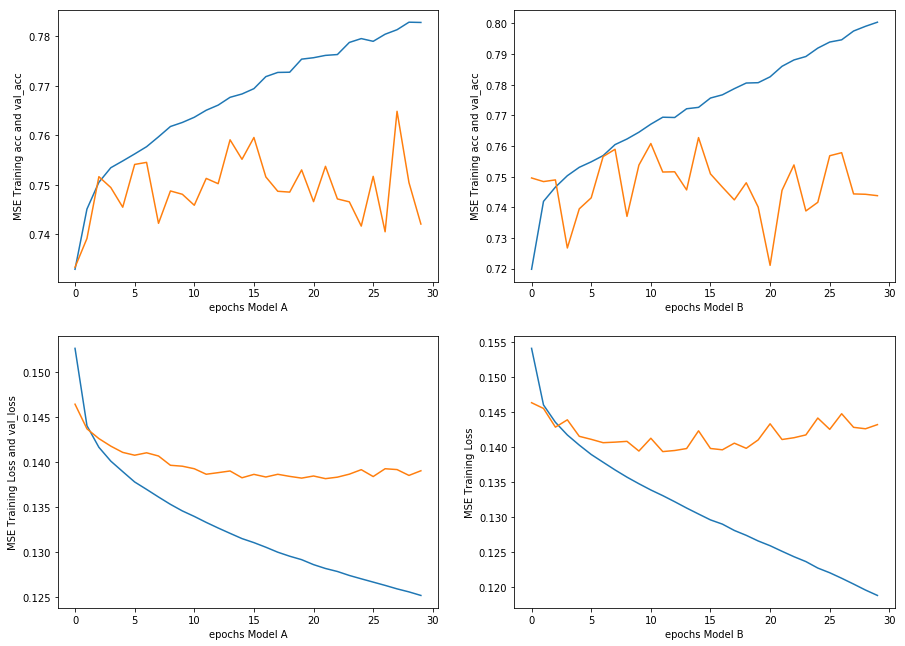

In [166]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(15,11))
plt.subplot(2,2,1)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs Model A')
plt.plot(historyA.history['f1_m'])

plt.plot(historyA.history['val_f1_m'])


plt.subplot(2,2,3)
plt.plot(historyA.history['loss'])
plt.ylabel('MSE Training Loss and val_loss')
plt.plot(historyA.history['val_loss'])
plt.xlabel('epochs Model A')


plt.subplot(2,2,2)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs Model B')
plt.plot(historyB.history['f1_m'])
plt.plot(historyB.history['val_f1_m'])


plt.subplot(2,2,4)
plt.plot(historyB.history['loss'])
plt.ylabel('MSE Training Loss')
plt.plot(historyB.history['val_loss'])
plt.xlabel('epochs Model B')

Model A and model B have a diffrent number of layers:

* Model A has 5 layers 
* Model B has 7 layers 

The accuracy of model B reached as high as 81% but validation loss increased and resulted in a loss of validation accuracy because of over-fitting the data as the number of layers increase. Model B provided a better F1 accuracy with a minimum validation loss when iterations were kept below 15 and therefore performed better than model A.



### MLP

In [167]:
inputs = Input(shape=(X_train_ar.shape[1],))
x = Dense(units=100, activation='relu')(inputs)
x = Dense(units=50, activation='relu')(x)
x = Dense(units=25, activation='relu')(x)
#x = Dense(units=15, activation='relu')(x)
#x = Dense(units=10, activation='relu')(x)
predictions = Dense(1,activation='sigmoid')(x)
modelMLP1 = Model(inputs=inputs, outputs=predictions)


In [168]:
modelMLP1.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

modelMLP1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 14)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 100)               1500      
_________________________________________________________________
dense_12 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_13 (Dense)             (None, 25)                1275      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 26        
Total params: 7,851
Trainable params: 7,851
Non-trainable params: 0
_________________________________________________________________


In [169]:
historyMLP1 = modelMLP1.fit(X_train_ar,
                    y_train, 
                    epochs=15, 
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_test_ar, y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/15
62604/62604 [==============================] - 3s 43us/step - loss: 0.2101 - acc: 0.6839 - f1_m: 0.4936 - val_loss: 0.1832 - val_acc: 0.7447 - val_f1_m: 0.6673
Epoch 2/15
62604/62604 [==============================] - 2s 25us/step - loss: 0.1694 - acc: 0.7555 - f1_m: 0.6979 - val_loss: 0.1585 - val_acc: 0.7703 - val_f1_m: 0.7249
Epoch 3/15
62604/62604 [==============================] - 2s 24us/step - loss: 0.1564 - acc: 0.7697 - f1_m: 0.7311 - val_loss: 0.1523 - val_acc: 0.7768 - val_f1_m: 0.7456
Epoch 4/15
62604/62604 [==============================] - 2s 26us/step - loss: 0.1526 - acc: 0.7742 - f1_m: 0.7395 - val_loss: 0.1499 - val_acc: 0.7790 - val_f1_m: 0.7429
Epoch 5/15
62604/62604 [==============================] - 2s 26us/step - loss: 0.1507 - acc: 0.7763 - f1_m: 0.7418 - val_loss: 0.1485 - val_acc: 0.7826 - val_f1_m: 0.7456
Epoch 6/15
62604/62604 [==============================] - 2s 27us/step - loss: 0.1494 - acc: 0.

In [170]:
%%time

modelB.compile(optimizer='adagrad',
              loss='mean_squared_error',
              metrics=['acc', f1_m])

# lets also add the history variable to see how we are doing
# and lets add a validation set to keep track of our progress
historyB = modelB.fit(X_ints_train+ [X_train_ar],
                    y_train, 
                    epochs=15,  
                    batch_size=50, 
                    verbose=1, 
                    validation_data = (X_ints_test + [X_test_ar], y_test))

Train on 62604 samples, validate on 15652 samples
Epoch 1/15
62604/62604 [==============================] - 4s 66us/step - loss: 0.1353 - acc: 0.8022 - f1_m: 0.7645 - val_loss: 0.1398 - val_acc: 0.7925 - val_f1_m: 0.7557
Epoch 2/15
62604/62604 [==============================] - 3s 45us/step - loss: 0.1270 - acc: 0.8178 - f1_m: 0.7826 - val_loss: 0.1422 - val_acc: 0.7882 - val_f1_m: 0.7329
Epoch 3/15
62604/62604 [==============================] - 3s 45us/step - loss: 0.1234 - acc: 0.8247 - f1_m: 0.7909 - val_loss: 0.1482 - val_acc: 0.7760 - val_f1_m: 0.7183
Epoch 4/15
62604/62604 [==============================] - 3s 45us/step - loss: 0.1207 - acc: 0.8303 - f1_m: 0.7965 - val_loss: 0.1428 - val_acc: 0.7856 - val_f1_m: 0.7398
Epoch 5/15
62604/62604 [==============================] - 3s 46us/step - loss: 0.1182 - acc: 0.8370 - f1_m: 0.8046 - val_loss: 0.1435 - val_acc: 0.7886 - val_f1_m: 0.7478
Epoch 6/15
62604/62604 [==============================] - 3s 45us/step - loss: 0.1161 - acc: 0.

In [171]:
from sklearn import metrics as mt
yhat_proba = modelMLP1.predict(X_test_ar)
yhatMLP = np.round(yhat_proba)
print(mt.confusion_matrix(y_test,yhatMLP),mt.accuracy_score(y_test,yhat))


from sklearn import metrics as mt
yhat_proba1 = modelB.predict(X_ints_test+ [X_test_ar])
yhatB = np.round(yhat_proba1)
print(mt.confusion_matrix(y_test,yhatB),mt.accuracy_score(y_test,yhatB))

[[7400 1595]
 [1677 4980]] 0.7928060311781242
[[7578 1417]
 [1924 4733]] 0.7865448504983389


Text(0.5, 0, 'epochs MLP')

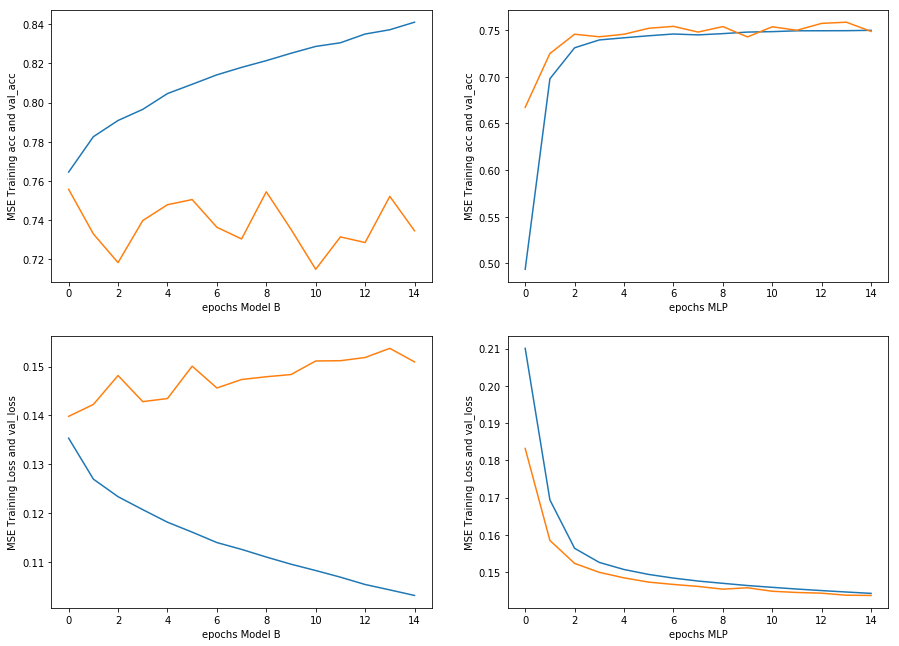

In [172]:
plt.figure(figsize=(15,11))
plt.subplot(2,2,1)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs Model B')
plt.plot(historyB.history['f1_m'])

plt.plot(historyB.history['val_f1_m'])


plt.subplot(2,2,3)
plt.plot(historyB.history['loss'])
plt.ylabel('MSE Training Loss and val_loss')
plt.plot(historyB.history['val_loss'])
plt.xlabel('epochs Model B')


plt.subplot(2,2,2)
plt.ylabel('MSE Training acc and val_acc')
plt.xlabel('epochs MLP')
plt.plot(historyMLP1.history['f1_m'])

plt.plot(historyMLP1.history['val_f1_m'])


plt.subplot(2,2,4)
plt.plot(historyMLP1.history['loss'])
plt.ylabel('MSE Training Loss and val_loss')
plt.plot(historyMLP1.history['val_loss'])
plt.xlabel('epochs MLP')

#### 2.3 Comparing Models with Standard MLP

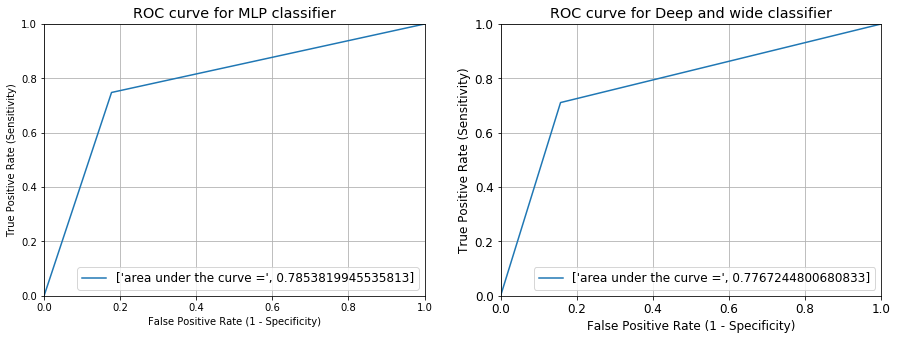

In [173]:
from sklearn import metrics

# plot MLP
fpr, tpr, thresholds = metrics.roc_curve(y_test, yhatMLP)
AUCMLP=metrics.roc_auc_score(y_test, yhatMLP)
AUCB=metrics.roc_auc_score(y_test, yhatB)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(fpr, tpr,label= ['area under the curve =',AUCMLP])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for MLP classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.legend()
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# plot model B (highest performer)
fpr, tpr, thresholds = metrics.roc_curve(y_test, yhatB)
plt.subplot(1,2,2)
plt.plot(fpr, tpr,label= ['area under the curve =',AUCB])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Deep and wide classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend()
plt.grid(True)

The plots above compares MLP with our highes performing deep and wide classifier. Below are several observations:

* The F1 score for our wide and deep model is higher than the MLP.
* The F1 valdation accuracy for our wide and deep model is slightly better on average than MLP.
* One key difference between our wide and deep model and our MLP model is that there is a large difference between the validation accuracy and the accuracy.
    * The wide and deep model performed much better with the training data than the testing data because wide and deep networks are beter a generalization.
    * The deep network had the same results for both the training and test data sets which means that is was better at classifing our data set using only memorization.

Both models had similar results, but the wide and deep model did slightly better than MLP. 


Because both models performed so similarly, lets look at an additional method for comparing these models. The McNemars test is a test proposed in \[1\] to compare machine learning models. It examines the performance of two models on the same dataset by determining whether or not there is significant difference between the incorrect results.


In [124]:
# debugging option
#pd.options.display.max_rows = 50

from statsmodels.stats.contingency_tables import mcnemar

# copy ytest for reshape
y_test_c = y_test.copy()
#np.reshape(y_test_c, -1, 1)
y_test_c = y_test_c[np.newaxis].T

# build contingency table
contab = pd.DataFrame({'mlp_correct':np.equal(y_test_c, yhatMLP).flatten(),'b_correct':np.equal(y_test_c, yhatB).flatten()},index=range(0,len(y_test_c)))
xtab = pd.crosstab(contab.mlp_correct, contab.b_correct)
xtab.sort_index(ascending=False, inplace=True)
xtab.sort_index(ascending=False, inplace=True, axis=1)
print('Contingency table for McNemar Test:\n', xtab, '\n')

# This example taken from https://machinelearningmastery.com/mcnemars-test-for-machine-learning/ and modified for use in this lab
# calculate mcnemar test
result = mcnemar(xtab, exact=True)
# print findings
print('statistic=%.2f, p-value=%.2f' % (result.statistic, result.pvalue))
# compare p-value to alpha
alpha = 0.05
if result.pvalue > alpha:
    print('Same proportions of errors')
else:
    print('Different proportions of errors')


Contingency table for McNemar Test:
 b_correct    True   False
mlp_correct              
True         10776   1631
False         1283   1962 

statistic=1283.00, p-value=0.00
Different proportions of errors


Based on the result, the two models produce different proportions of errors and therefore perform quite differently.

### 3. Exceptional Work
---

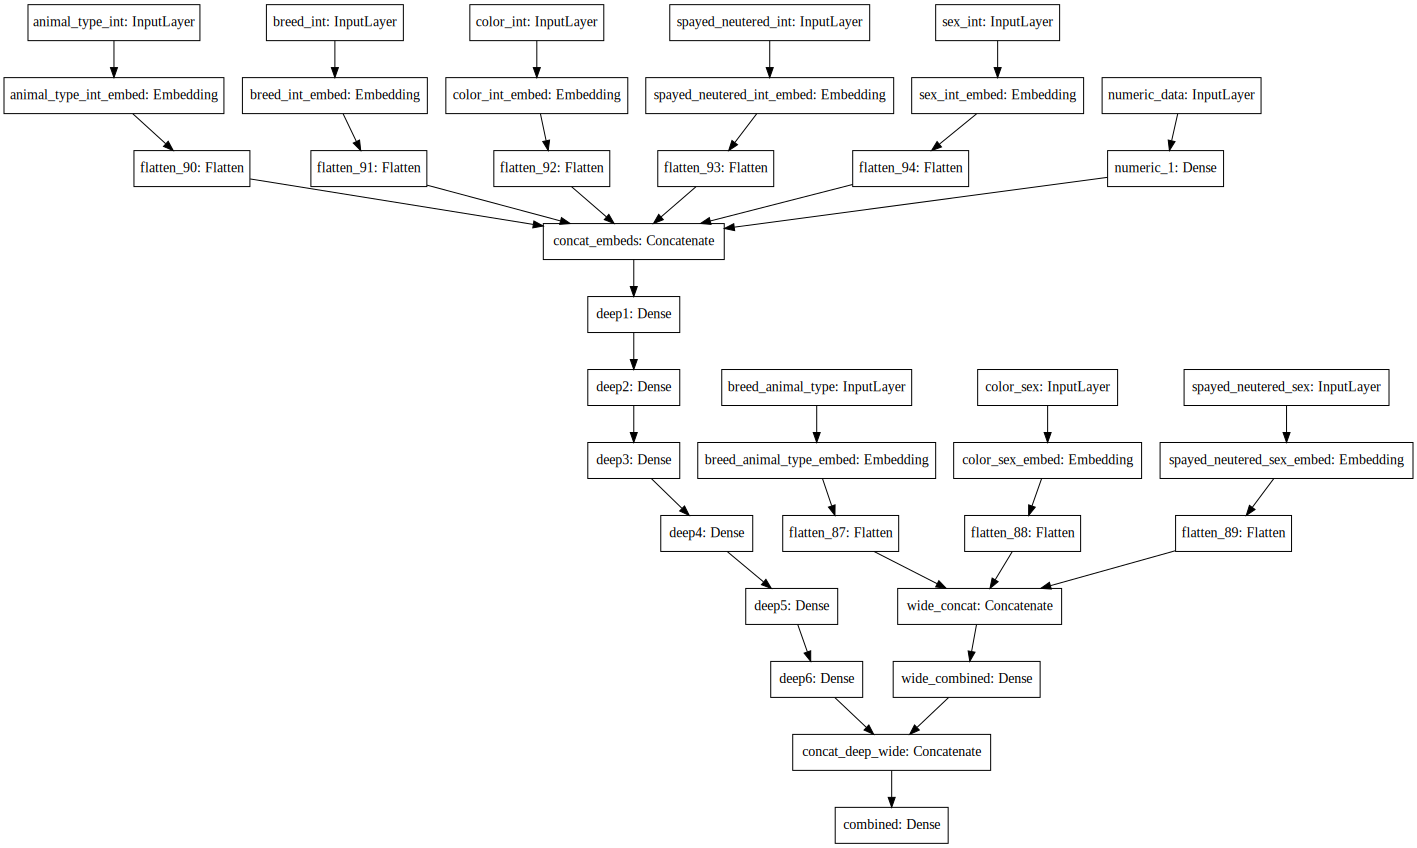

In [150]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# you will need to install pydot properly on your machine to get this running
SVG(model_to_dot(modelB).create(prog='dot', format='svg'))

In [ ]:
modelB.layers[0].get_weights()

In [24]:
for layer in modelB.layers: 
    print(layer.get_config(), layer.get_weights())

{'batch_input_shape': (None, 1), 'dtype': 'int32', 'sparse': False, 'name': 'animal_type_int'} []
{'batch_input_shape': (None, 1), 'dtype': 'int32', 'sparse': False, 'name': 'breed_int'} []
{'batch_input_shape': (None, 1), 'dtype': 'int32', 'sparse': False, 'name': 'color_int'} []
{'batch_input_shape': (None, 1), 'dtype': 'int32', 'sparse': False, 'name': 'spayed_neutered_int'} []
{'batch_input_shape': (None, 1), 'dtype': 'int32', 'sparse': False, 'name': 'sex_int'} []
{'name': 'animal_type_int_embed', 'trainable': True, 'batch_input_shape': (None, 1), 'dtype': 'float32', 'input_dim': 5, 'output_dim': 2, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': 1} [array([[ 0.03084215,  0.07599948],
       [ 0.14617625, -0.03274135],
       [-0.11578513, -0.10719546],
       [ 0.00597006, -0.07511391

In [31]:
np.unique(cats.color)

array(['agouti', 'apricot', 'black', 'black brindle', 'black smoke',
       'black tabby', 'black tiger', 'blue', 'blue cream', 'blue merle',
       'blue point', 'blue smoke', 'blue tabby', 'blue tick',
       'blue tiger', 'brown', 'brown brindle', 'brown merle',
       'brown tabby', 'brown tiger', 'buff', 'calico', 'calico point',
       'chocolate', 'chocolate point', 'cream', 'cream tabby', 'fawn',
       'flame point', 'gold', 'gray', 'gray tabby', 'green',
       'lilac point', 'liver', 'liver tick', 'lynx point', 'orange',
       'orange tabby', 'orange tiger', 'pink', 'red', 'red merle',
       'red tick', 'ruddy', 'sable', 'seal point', 'silver',
       'silver lynx point', 'silver tabby', 'tan', 'torbie', 'tortie',
       'tortie point', 'tricolor', 'white', 'yellow', 'yellow brindle'],
      dtype=object)

In [26]:
np.unique(cats.animal_type)

array(['Bird', 'Cat', 'Dog', 'Livestock', 'Other'], dtype=object)

In [116]:
modelB.get_weights()[0].T

array([[-0.07719671, -0.08505347,  0.13727787,  0.03994062, -0.22019257],
       [-0.1664997 ,  0.17760527, -0.11737197, -0.00690545,  0.2879222 ]],
      dtype=float32)

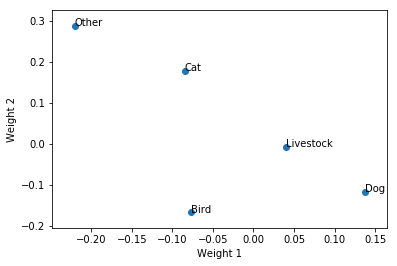

In [122]:
##visualize animal types 
y = modelB.get_weights()[0].T[0]
z = modelB.get_weights()[0].T[1]
n = ['Bird', 'Cat', 'Dog', 'Livestock', 'Other']

fig, ax = plt.subplots()
ax.scatter(y, z)

for i, txt in enumerate(n):
    ax.annotate(txt, (y[i], z[i]))
plt.xlabel("Weight 1")
plt.ylabel("Weight 2")

plt.show()

The above graph indicates that the animal types are independant and no dimensionality reduction is required on the animal type attribute.

### 4. References
---

\[1\] Dietterich, Thomas G. "Approximate statistical tests for comparing supervised classification learning algorithms." Neural computation 10.7 (1998): 1895-1923.  
\[2\] https://machinelearningmastery.com/mcnemars-test-for-machine-learning/